In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
df_train = pd.read_csv('/content/gdrive/MyDrive/CSE256_SP23/project/medical_abstract_data/medical_tc_train.csv', index_col=0)
df_train.reset_index(inplace=True)
df_train.columns=['label', 'text']
df_train.label = df_train.label.values-1
df_test = pd.read_csv('/content/gdrive/MyDrive/CSE256_SP23/project/medical_abstract_data/medical_tc_test.csv', index_col=0)
df_test.reset_index(inplace=True)
df_test.columns=['label', 'text']
df_test.label = df_test.label.values-1
df_train['text_len'] = df_train['text'].apply(len).values
df_test['text_len'] = df_test['text'].apply(len).values

max_length=128
df_train['text'] = df_train.text.apply(lambda x:x[:max_length])
df_test['text'] = df_test.text.apply(lambda x:x[:max_length])

In [3]:
len(df_train), len(df_test)

(11550, 2888)

In [4]:
!pip install medclip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 50.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [5]:
from torch.utils.data import Dataset, DataLoader, RandomSampler
from medclip import MedCLIPTextModel, MedCLIPProcessor
class TextClassifyDataset(Dataset):
  def __init__(self, df):
    self.texts = df.text.values
    self.labels = df.label.values

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, index):
    text = self.texts[index]
    label = self.labels[index]
    return text, label

In [6]:
train_dataset = TextClassifyDataset(df_train)
test_dataset = TextClassifyDataset(df_test)

In [7]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 256

train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size
)

test_dataloader = DataLoader(
    test_dataset,
    sampler = SequentialSampler(test_dataset),
    batch_size = batch_size
)

In [8]:
import torch
import torch.nn as nn

class CLIPClassifier(nn.Module):
  def __init__(self, hidden_size = 512, class_num = 5):
    super().__init__()
    self.clip_text_model = MedCLIPTextModel()
    for param in self.clip_text_model.parameters():
      param.requires_grad = False

    self.hidden_size = hidden_size
    self.class_num = class_num
    self.mlp = nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size), 
                   nn.ReLU(),
                   )
    self.classifier = nn.Linear(self.hidden_size, self.class_num)

  def forward(self, input_ids, attention_mask):
    embed = self.clip_text_model(input_ids, attention_mask)
    embed = self.mlp(embed)
    output = self.classifier(embed)
    return output

In [9]:
model = CLIPClassifier().cuda()
processor = MedCLIPProcessor()

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [10]:
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
# function to get validation accuracy
def get_validation_performance(dataloader, criterion):
    # Put the model in evaluation mode
    model.eval()
    all_preds = []
    all_labels = []
    # Tracking variables 
    total_eval_loss = 0

    total_correct = 0

    for i,batch in enumerate(dataloader):
      texts, labels = batch[0], batch[1]
      batch = processor(text=texts, return_tensors='pt', padding=True)
      b_input_ids = batch['input_ids'].to(device)
      b_input_mask = batch['attention_mask'].to(device)
      b_labels = labels.to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        loss = criterion(outputs, b_labels)
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = outputs.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        #print(pred_flat, labels_flat)
        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct
        all_preds.append(pred_flat)
        all_labels.append(labels_flat)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = accuracy_score(np.concatenate(all_labels).flatten(),np.concatenate(all_preds).flatten())
    print("Test Accuracy:",avg_val_accuracy,"\n")
    print(classification_report(np.concatenate(all_labels).flatten(),np.concatenate(all_preds).flatten()))
    return avg_val_accuracy

In [11]:
import torch.optim as optim
epochs = 20
device = 'cuda'
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())

In [12]:
# For each epoch...
train_loss_list = []
train_acc_list = []
test_acc_list = []
highest_test_acc = 0

for epoch_i in range(0, epochs):
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()
    total_correct = 0

    for i, batch in tqdm(enumerate(train_dataloader)):
      texts, labels = batch[0], batch[1]
      batch = processor(text=texts, return_tensors='pt', padding=True)
      b_input_ids = batch['input_ids'].to(device)
      b_input_mask = batch['attention_mask'].to(device)
      b_labels = labels.to(device)

      # Clear the previously calculated gradient
      model.zero_grad()        

      # Perform a forward pass (evaluate the model on this training batch).
      outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
      loss = criterion(outputs, b_labels)
      total_train_loss += loss.item()
      loss.backward()

      # Update parameters and take a step using the computed gradient.
      optimizer.step()

      logits = outputs.detach().cpu().numpy()
      pred_flat = np.argmax(logits, axis=1).flatten()
      label_ids = b_labels.to('cpu').numpy()
      labels_flat = label_ids.flatten()
      
      num_correct = np.sum(pred_flat == labels_flat)
      total_correct += num_correct

    total_train_loss /= (len(train_dataloader)*batch_size)
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set. Implement this function in the cell above.
    print(f"Total loss: {total_train_loss}")
    train_acc = float(total_correct) / (len(train_dataloader)*batch_size)
    print(f"Training accuracy: {train_acc}")
    test_acc = get_validation_performance(test_dataloader, criterion)
    #print(f"Test accuracy: {test_acc}")
    train_loss_list.append(total_train_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    if test_acc > highest_test_acc:
      highest_test_acc = test_acc
      torch.save(model.state_dict(), '/content/gdrive/MyDrive/CSE256_SP23/project/clip_classifier_model.pth')


======== Epoch 1 / 20 ========
Training...


46it [00:29,  1.54it/s]


Total loss: 0.005644648831904582
Training accuracy: 0.36931046195652173
Test Accuracy: 0.47056786703601106 

              precision    recall  f1-score   support

           0       0.71      0.51      0.60       633
           1       0.00      0.00      0.00       299
           2       0.00      0.00      0.00       385
           3       0.63      0.49      0.55       610
           4       0.38      0.77      0.50       961

    accuracy                           0.47      2888
   macro avg       0.34      0.35      0.33      2888
weighted avg       0.41      0.47      0.41      2888



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



======== Epoch 2 / 20 ========
Training...


46it [00:29,  1.59it/s]


Total loss: 0.004802132389791634
Training accuracy: 0.48624320652173914
Test Accuracy: 0.4986149584487535 

              precision    recall  f1-score   support

           0       0.57      0.83      0.67       633
           1       0.50      0.00      0.01       299
           2       0.70      0.04      0.08       385
           3       0.61      0.59      0.60       610
           4       0.40      0.57      0.47       961

    accuracy                           0.50      2888
   macro avg       0.55      0.40      0.36      2888
weighted avg       0.53      0.50      0.44      2888


======== Epoch 3 / 20 ========
Training...


46it [00:32,  1.40it/s]


Total loss: 0.004473981407025586
Training accuracy: 0.5144361413043478
Test Accuracy: 0.5273545706371191 

              precision    recall  f1-score   support

           0       0.72      0.61      0.66       633
           1       0.59      0.05      0.10       299
           2       0.57      0.36      0.45       385
           3       0.60      0.66      0.63       610
           4       0.41      0.61      0.49       961

    accuracy                           0.53      2888
   macro avg       0.58      0.46      0.46      2888
weighted avg       0.56      0.53      0.51      2888


======== Epoch 4 / 20 ========
Training...


46it [00:32,  1.43it/s]


Total loss: 0.004285972008643591
Training accuracy: 0.5309103260869565
Test Accuracy: 0.5484764542936288 

              precision    recall  f1-score   support

           0       0.62      0.79      0.70       633
           1       0.51      0.29      0.37       299
           2       0.56      0.45      0.50       385
           3       0.57      0.74      0.64       610
           4       0.46      0.38      0.42       961

    accuracy                           0.55      2888
   macro avg       0.54      0.53      0.53      2888
weighted avg       0.54      0.55      0.53      2888


======== Epoch 5 / 20 ========
Training...


46it [00:31,  1.48it/s]


Total loss: 0.004170952471094611
Training accuracy: 0.5446671195652174
Test Accuracy: 0.5439750692520776 

              precision    recall  f1-score   support

           0       0.68      0.70      0.69       633
           1       0.52      0.31      0.39       299
           2       0.58      0.34      0.43       385
           3       0.58      0.73      0.65       610
           4       0.43      0.47      0.45       961

    accuracy                           0.54      2888
   macro avg       0.56      0.51      0.52      2888
weighted avg       0.55      0.54      0.54      2888


======== Epoch 6 / 20 ========
Training...


46it [00:31,  1.44it/s]


Total loss: 0.004141337450836663
Training accuracy: 0.5467900815217391
Test Accuracy: 0.5491689750692521 

              precision    recall  f1-score   support

           0       0.67      0.73      0.70       633
           1       0.53      0.34      0.41       299
           2       0.60      0.28      0.38       385
           3       0.59      0.71      0.65       610
           4       0.44      0.50      0.47       961

    accuracy                           0.55      2888
   macro avg       0.57      0.51      0.52      2888
weighted avg       0.55      0.55      0.54      2888


======== Epoch 7 / 20 ========
Training...


46it [00:31,  1.46it/s]


Total loss: 0.004095443757250905
Training accuracy: 0.5602072010869565
Test Accuracy: 0.5408587257617729 

              precision    recall  f1-score   support

           0       0.68      0.69      0.68       633
           1       0.49      0.43      0.46       299
           2       0.59      0.35      0.44       385
           3       0.65      0.54      0.59       610
           4       0.42      0.55      0.48       961

    accuracy                           0.54      2888
   macro avg       0.57      0.51      0.53      2888
weighted avg       0.56      0.54      0.54      2888


======== Epoch 8 / 20 ========
Training...


46it [00:31,  1.44it/s]


Total loss: 0.004085262913418853
Training accuracy: 0.5580842391304348
Test Accuracy: 0.5637119113573407 

              precision    recall  f1-score   support

           0       0.67      0.74      0.70       633
           1       0.51      0.40      0.45       299
           2       0.55      0.46      0.50       385
           3       0.61      0.70      0.65       610
           4       0.47      0.45      0.46       961

    accuracy                           0.56      2888
   macro avg       0.56      0.55      0.55      2888
weighted avg       0.56      0.56      0.56      2888


======== Epoch 9 / 20 ========
Training...


46it [00:31,  1.46it/s]


Total loss: 0.004038394170651293
Training accuracy: 0.559188179347826
Test Accuracy: 0.556786703601108 

              precision    recall  f1-score   support

           0       0.67      0.74      0.71       633
           1       0.52      0.40      0.45       299
           2       0.61      0.32      0.42       385
           3       0.57      0.75      0.65       610
           4       0.46      0.46      0.46       961

    accuracy                           0.56      2888
   macro avg       0.57      0.53      0.54      2888
weighted avg       0.56      0.56      0.55      2888


======== Epoch 10 / 20 ========
Training...


46it [00:31,  1.45it/s]


Total loss: 0.00400618183851728
Training accuracy: 0.5660665760869565
Test Accuracy: 0.5647506925207756 

              precision    recall  f1-score   support

           0       0.65      0.76      0.71       633
           1       0.54      0.38      0.45       299
           2       0.56      0.45      0.50       385
           3       0.58      0.76      0.66       610
           4       0.48      0.41      0.44       961

    accuracy                           0.56      2888
   macro avg       0.56      0.55      0.55      2888
weighted avg       0.56      0.56      0.55      2888


======== Epoch 11 / 20 ========
Training...


46it [00:31,  1.46it/s]


Total loss: 0.0039823808930004425
Training accuracy: 0.5613960597826086
Test Accuracy: 0.5657894736842105 

              precision    recall  f1-score   support

           0       0.66      0.75      0.71       633
           1       0.52      0.44      0.48       299
           2       0.55      0.47      0.51       385
           3       0.59      0.75      0.66       610
           4       0.48      0.40      0.44       961

    accuracy                           0.57      2888
   macro avg       0.56      0.56      0.56      2888
weighted avg       0.56      0.57      0.56      2888


======== Epoch 12 / 20 ========
Training...


46it [00:31,  1.44it/s]


Total loss: 0.003908886199655092
Training accuracy: 0.5752377717391305
Test Accuracy: 0.5585180055401662 

              precision    recall  f1-score   support

           0       0.69      0.70      0.69       633
           1       0.57      0.28      0.38       299
           2       0.57      0.45      0.50       385
           3       0.66      0.59      0.62       610
           4       0.45      0.58      0.50       961

    accuracy                           0.56      2888
   macro avg       0.59      0.52      0.54      2888
weighted avg       0.57      0.56      0.56      2888


======== Epoch 13 / 20 ========
Training...


46it [00:31,  1.45it/s]


Total loss: 0.003953647268328654
Training accuracy: 0.5704823369565217
Test Accuracy: 0.5547091412742382 

              precision    recall  f1-score   support

           0       0.60      0.82      0.69       633
           1       0.59      0.29      0.39       299
           2       0.62      0.27      0.38       385
           3       0.61      0.71      0.66       610
           4       0.46      0.47      0.46       961

    accuracy                           0.55      2888
   macro avg       0.58      0.52      0.52      2888
weighted avg       0.56      0.55      0.54      2888


======== Epoch 14 / 20 ========
Training...


46it [00:31,  1.46it/s]


Total loss: 0.00391985066032604
Training accuracy: 0.5748980978260869
Test Accuracy: 0.5623268698060941 

              precision    recall  f1-score   support

           0       0.68      0.72      0.70       633
           1       0.50      0.53      0.51       299
           2       0.48      0.59      0.53       385
           3       0.66      0.63      0.64       610
           4       0.47      0.41      0.44       961

    accuracy                           0.56      2888
   macro avg       0.56      0.58      0.57      2888
weighted avg       0.56      0.56      0.56      2888


======== Epoch 15 / 20 ========
Training...


46it [00:31,  1.47it/s]


Total loss: 0.003925587399862707
Training accuracy: 0.5734544836956522
Test Accuracy: 0.5592105263157895 

              precision    recall  f1-score   support

           0       0.58      0.85      0.69       633
           1       0.55      0.46      0.50       299
           2       0.56      0.45      0.50       385
           3       0.56      0.81      0.66       610
           4       0.53      0.28      0.37       961

    accuracy                           0.56      2888
   macro avg       0.55      0.57      0.54      2888
weighted avg       0.55      0.56      0.53      2888


======== Epoch 16 / 20 ========
Training...


46it [00:33,  1.39it/s]


Total loss: 0.003902451145341215
Training accuracy: 0.5734544836956522
Test Accuracy: 0.5626731301939059 

              precision    recall  f1-score   support

           0       0.63      0.80      0.70       633
           1       0.57      0.37      0.45       299
           2       0.56      0.44      0.49       385
           3       0.55      0.82      0.66       610
           4       0.50      0.35      0.42       961

    accuracy                           0.56      2888
   macro avg       0.56      0.56      0.54      2888
weighted avg       0.55      0.56      0.54      2888


======== Epoch 17 / 20 ========
Training...


46it [00:31,  1.45it/s]


Total loss: 0.003914727854704403
Training accuracy: 0.5696331521739131
Test Accuracy: 0.5647506925207756 

              precision    recall  f1-score   support

           0       0.65      0.78      0.71       633
           1       0.57      0.31      0.41       299
           2       0.57      0.43      0.49       385
           3       0.56      0.79      0.66       610
           4       0.48      0.41      0.44       961

    accuracy                           0.56      2888
   macro avg       0.57      0.55      0.54      2888
weighted avg       0.56      0.56      0.55      2888


======== Epoch 18 / 20 ========
Training...


46it [00:31,  1.46it/s]


Total loss: 0.003853436777084742
Training accuracy: 0.580078125
Test Accuracy: 0.5602493074792244 

              precision    recall  f1-score   support

           0       0.59      0.83      0.69       633
           1       0.55      0.36      0.43       299
           2       0.51      0.51      0.51       385
           3       0.65      0.66      0.65       610
           4       0.48      0.40      0.44       961

    accuracy                           0.56      2888
   macro avg       0.56      0.55      0.55      2888
weighted avg       0.55      0.56      0.55      2888


======== Epoch 19 / 20 ========
Training...


46it [00:31,  1.45it/s]


Total loss: 0.003826819552594553
Training accuracy: 0.583389945652174
Test Accuracy: 0.5723684210526315 

              precision    recall  f1-score   support

           0       0.64      0.79      0.71       633
           1       0.55      0.42      0.48       299
           2       0.55      0.46      0.50       385
           3       0.64      0.66      0.65       610
           4       0.48      0.47      0.47       961

    accuracy                           0.57      2888
   macro avg       0.57      0.56      0.56      2888
weighted avg       0.57      0.57      0.57      2888


======== Epoch 20 / 20 ========
Training...


46it [00:31,  1.45it/s]


Total loss: 0.0038187736898417706
Training accuracy: 0.5799082880434783
Test Accuracy: 0.5619806094182825 

              precision    recall  f1-score   support

           0       0.67      0.74      0.70       633
           1       0.56      0.33      0.42       299
           2       0.55      0.46      0.50       385
           3       0.57      0.76      0.65       610
           4       0.47      0.43      0.45       961

    accuracy                           0.56      2888
   macro avg       0.56      0.54      0.55      2888
weighted avg       0.56      0.56      0.55      2888



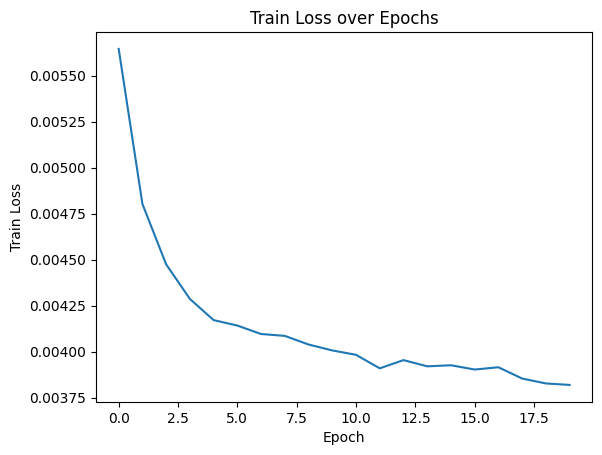

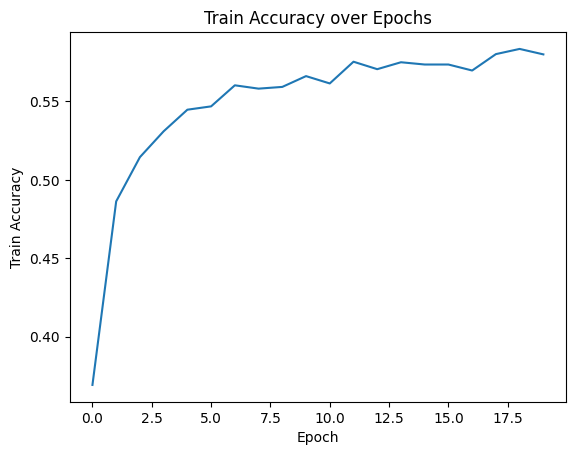

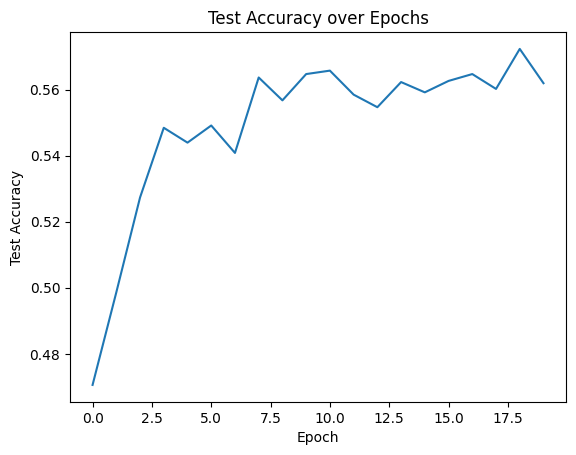

In [13]:
import matplotlib.pyplot as plt
def plot_graph(list_data, title = ''):
  fig, ax = plt.subplots()
# Plot the training loss
  ax.plot(list_data)
  # Set the labels and title
  ax.set_xlabel('Epoch')
  ax.set_ylabel(title)
  ax.set_title(f'{title} over Epochs')
  # Display the plot
  plt.show()

plot_graph(train_loss_list, title = 'Train Loss')
plot_graph(train_acc_list, title = 'Train Accuracy')
plot_graph(test_acc_list, title = 'Test Accuracy')

In [14]:
test_acc_list

[0.47056786703601106,
 0.4986149584487535,
 0.5273545706371191,
 0.5484764542936288,
 0.5439750692520776,
 0.5491689750692521,
 0.5408587257617729,
 0.5637119113573407,
 0.556786703601108,
 0.5647506925207756,
 0.5657894736842105,
 0.5585180055401662,
 0.5547091412742382,
 0.5623268698060941,
 0.5592105263157895,
 0.5626731301939059,
 0.5647506925207756,
 0.5602493074792244,
 0.5723684210526315,
 0.5619806094182825]

In [15]:
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
# function to get validation accuracy
def get_error_examples(dataloader):
    # Put the model in evaluation mode
    model.eval()
    error_examples = []

    for i,batch in enumerate(dataloader):
      texts, labels = batch[0], batch[1]
      batch = processor(text=texts, return_tensors='pt', padding=True)
      b_input_ids = batch['input_ids'].to(device)
      b_input_mask = batch['attention_mask'].to(device)
      b_labels = labels.to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        loss = criterion(outputs, b_labels)

        logits = outputs.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        
        for j, equal in enumerate(pred_flat == labels_flat):
          if not equal:
            error_examples.append((batch_size*i+j, texts[j], int(labels[j].numpy()), pred_flat[j]))
            
    return error_examples

In [16]:
model = CLIPClassifier().cuda()
processor = MedCLIPProcessor()
device = 'cuda'
criterion = nn.CrossEntropyLoss()
get_validation_performance(test_dataloader,criterion)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor

Test Accuracy: 0.2157202216066482 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       633
           1       0.17      0.07      0.10       299
           2       0.00      0.00      0.00       385
           3       0.22      0.99      0.36       610
           4       0.00      0.00      0.00       961

    accuracy                           0.22      2888
   macro avg       0.08      0.21      0.09      2888
weighted avg       0.06      0.22      0.09      2888



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.2157202216066482

In [17]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/CSE256_SP23/project/clip_classifier_model.pth'))
get_validation_performance(test_dataloader, criterion)

Test Accuracy: 0.5723684210526315 

              precision    recall  f1-score   support

           0       0.64      0.79      0.71       633
           1       0.55      0.42      0.48       299
           2       0.55      0.46      0.50       385
           3       0.64      0.66      0.65       610
           4       0.48      0.47      0.47       961

    accuracy                           0.57      2888
   macro avg       0.57      0.56      0.56      2888
weighted avg       0.57      0.57      0.57      2888



0.5723684210526315

In [18]:
error_examples = get_error_examples(test_dataloader)

In [19]:
import pandas as pd
error_df = pd.DataFrame(columns=['index', 'text', 'label', 'pred'])

for row in error_examples:
    error_df.loc[len(error_df)] = row

error_df.head()

,index,text,label,pred
0,0,Obstructive sleep apnea following topical orop...,2,4
1,4,Paraneoplastic vasculitic neuropathy: a treata...,3,2
2,7,Questionable role of CNS radioprophylaxis in t...,0,4
3,8,Reversibility of hepatic fibrosis in experimen...,4,1
4,9,Current status of duplex Doppler ultrasound in...,1,3


In [20]:
len(error_examples)

1235

In [152]:
1235/2888

0.4276315789473684

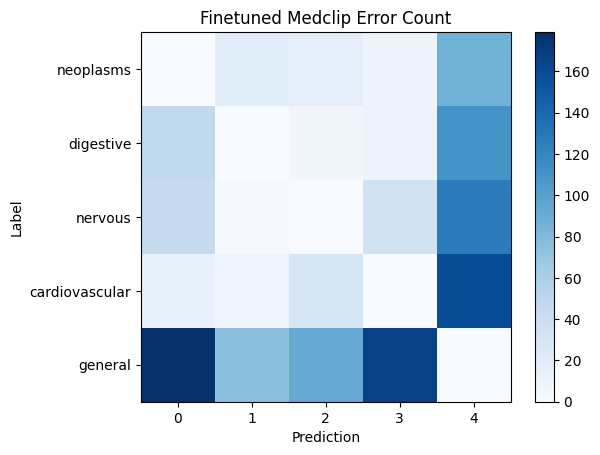

In [23]:
error_count = np.zeros((5,5))
for i in range(len(error_df)):
  error_count[error_df.loc[i]['label'],error_df.loc[i]['pred']] += 1

fig, ax = plt.subplots()

# Plot the heatmap using imshow
heatmap = ax.imshow(error_count, cmap='Blues', norm=plt.Normalize(vmin=0, vmax=np.max(error_count)))

# Add colorbar
cbar = plt.colorbar(heatmap)

# Set the title and labels
ax.set_title('Finetuned Medclip Error Count')
ax.set_xlabel('Prediction')
ax.set_ylabel('Label')

# Customize the tick labels for x and y axes
x_ticks = np.arange(5)
y_ticks = np.arange(5)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_yticklabels(['neoplasms', 'digestive', 'nervous', 'cardiovascular', 'general'])

# Display the plot
plt.show()

In [22]:
for i in range(len(error_df)):
  error_count[error_df.loc[i]['label'],error_df.loc[i]['pred']] += 1

from collections import defaultdict
error_cases = defaultdict(list)
for i in range(len(error_df)):
  error_cases[(error_df.loc[i]['label'],error_df.loc[i]['pred'])].append(error_df.loc[i]['text'])

In [24]:
error_cases[(4,0)]

['Evidence for intraluminal Ca++ regulatory site defect in sarcoplasmic reticulum from malignant hyperthermia pig muscle. Malignan',
 'The natural history of ultraviolet radiation-induced herpes simplex labialis and response to therapy with peroral and topical fo',
 "Leukaemia complicating treatment for Hodgkin's disease: the experience of the British National Lymphoma Investigation. OBJECTIVE",
 'Combined vesicovaginal-ureterovaginal fistulas associated with a vaginal foreign body. A case is presented of vesicovaginal-uret',
 'Photochemotherapy improves chronic cutaneous graft-versus-host disease. We have used oral psoralen photochemotherapy (PUVA) to t',
 'Assessing the clinical effectiveness of preventive maneuvers: analytic principles and systematic methods in reviewing evidence a',
 'Ruptured mature cystic teratoma of the ovary with recurrence in the liver and colon 17 years later. A case report. A mature cyst',
 'New biological properties of pyrroloquinoline quinone and its relat

In [128]:
label2id = {'neoplasms':0, 'digestive system diseases':1, 'nervous system diseases':2, 'cardiovascular diseases':3, 'general pathological conditions':4}

In [129]:
class ZeroShotClassifier(nn.Module):
  def __init__(self, class_names, prompt='This person may have'):
    super().__init__()
    self.class_names = class_names
    self.clip_text_model = MedCLIPTextModel().cuda()
    for param in self.clip_text_model.parameters():
      param.requires_grad = False
    self.cosine_sim = nn.CosineSimilarity()
    self.processor = MedCLIPProcessor()
    class_inputs = self.processor(text=self._prompt(class_names, prompt), return_tensors='pt', padding=True)
    self.class_outputs = self.clip_text_model(class_inputs['input_ids'].cuda(), class_inputs['attention_mask'].cuda())
    self.class_outputs = torch.nn.functional.normalize(self.class_outputs, dim=-1)

  def forward(self, texts):
    inputs = self.processor(text=texts, return_tensors='pt', padding=True)
    outputs = self.clip_text_model(inputs['input_ids'].cuda(), inputs['attention_mask'].cuda())
    outputs = torch.nn.functional.normalize(outputs, dim=-1)
    return outputs @ self.class_outputs.T

  def _prompt(self, class_names, prompt):
    prompts = []
    for i in range(len(class_names)):
      prompts.append('{} {}'.format(prompt, class_names[i])) 
    return prompts

In [130]:
import torch.optim as optim
from tqdm import tqdm
# function to get validation accuracy
def get_zero_shot_validation_performance(dataloader, k = 1):
    # Put the model in evaluation mode
    model.eval()

    total_correct = 0

    for i,batch in enumerate(dataloader):
      texts, labels = batch[0], batch[1]
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(texts)

        # Move logits and labels to CPU
        logits = outputs.detach().cpu()
        label_ids = labels.numpy()

        # Calculate the number of correctly labeled examples in batch
        top_k_logits, top_k_indices = torch.topk(logits, k=k, dim=1)
        is_in_top_k = torch.isin(torch.tensor(labels), top_k_indices)
        
        num_correct = np.sum(is_in_top_k.numpy())
        total_correct += num_correct
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / (len(dataloader)*batch_size)
    return avg_val_accuracy

In [132]:
model = ZeroShotClassifier(list(label2id.keys()))
for k in range(1,4):
  acc = get_zero_shot_validation_performance(test_dataloader, k=k)
  print('Zero shot top-{} accuracy: {}'.format(k, acc))

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-130-d74b0b8d5003>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or 

Zero shot top-1 accuracy: 0.6764322916666666
Zero shot top-2 accuracy: 0.9401041666666666
Zero shot top-3 accuracy: 0.9401041666666666


In [136]:
model = ZeroShotClassifier(list(label2id.keys()), prompt='The most possible disease is')
for k in range(1,4):
  acc = get_zero_shot_validation_performance(test_dataloader, k=k)
  print('Zero shot top-{} accuracy: {}'.format(k, acc))

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-130-d74b0b8d5003>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or 

Zero shot top-1 accuracy: 0.6956380208333334
Zero shot top-2 accuracy: 0.9401041666666666
Zero shot top-3 accuracy: 0.9401041666666666


In [139]:
model = ZeroShotClassifier(list(label2id.keys()), prompt='This patient has these symptoms. The most possible cause of these symptoms is')
for k in range(1,4):
  acc = get_zero_shot_validation_performance(test_dataloader, k=k)
  print('Zero shot top-{} accuracy: {}'.format(k, acc))

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-130-d74b0b8d5003>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or 

Zero shot top-1 accuracy: 0.6442057291666666
Zero shot top-2 accuracy: 0.9166666666666666
Zero shot top-3 accuracy: 0.9401041666666666


In [138]:
model = ZeroShotClassifier(list(label2id.keys()), prompt='This is the medical abstract of')
for k in range(1,4):
  acc = get_zero_shot_validation_performance(test_dataloader, k=k)
  print('Zero shot top-{} accuracy: {}'.format(k, acc))

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-130-d74b0b8d5003>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or 

Zero shot top-1 accuracy: 0.6806640625
Zero shot top-2 accuracy: 0.9401041666666666
Zero shot top-3 accuracy: 0.9401041666666666


In [121]:
import torch.optim as optim
from tqdm import tqdm
# function to get validation accuracy
def get_error_examples(dataloader,k=1):
    # Put the model in evaluation mode
    model.eval()

    error_examples = []

    for i,batch in enumerate(dataloader):
      texts, labels = batch[0], batch[1]
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(texts)

        # Move logits and labels to CPU
        logits = outputs.detach().cpu()
        label_ids = labels.numpy()

        # Calculate the number of correctly labeled examples in batch
        top_k_logits, top_k_indices = torch.topk(logits, k=k, dim=1)
        is_in_top_k = torch.isin(torch.tensor(labels), top_k_indices)
        for j, equal in enumerate(is_in_top_k):
          if not equal:
            error_examples.append((batch_size*i+j, texts[j], int(labels[j].numpy()), int(top_k_indices[j][0])))
        break
    return error_examples

In [141]:
model = ZeroShotClassifier(list(label2id.keys()), prompt='The most possible disease is')
error_examples = get_error_examples(test_dataloader, k=1)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-121-af3dfdc17600>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or 

In [144]:
len(error_examples)

85

In [143]:
error_examples

[(1,
  'Neutrophil function and pyogenic infections in bone marrow transplant recipients. In a consecutive entry trial, the incidence an',
  4,
  3),
 (2,
  'A phase II study of combined methotrexate and teniposide infusions prior to reinduction therapy in relapsed childhood acute lymp',
  4,
  0),
 (8,
  'Reversibility of hepatic fibrosis in experimentally induced cholestasis in rat. The reversibility of hepatic fibrosis was invest',
  4,
  3),
 (10,
  'The importance of congenital hypertrophy of the retinal pigment epithelium in familial adenomatous polyposis. We describe a fami',
  4,
  0),
 (12,
  'Gentamicin iontophoresis in the treatment of bacterial otitis externa in the guinea pig model. Pseudomonas otitis externa is one',
  4,
  1),
 (14,
  'Evidence for intraluminal Ca++ regulatory site defect in sarcoplasmic reticulum from malignant hyperthermia pig muscle. Malignan',
  4,
  0),
 (15,
  'Glutamic acid and gamma-aminobutyric acid neurotransmitters in central control of breath

In [43]:
model = ZeroShotClassifier(list(label2id.keys()), prompt='')
error_examples = get_error_examples(test_dataloader)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-42-b68254057842>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or s

In [140]:
len(error_examples)

85

In [145]:
import pandas as pd
error_df = pd.DataFrame(columns=['index', 'text', 'label', 'pred'])

for row in error_examples:
    error_df.loc[len(error_df)] = row

error_df.head()

,index,text,label,pred
0,1,Neutrophil function and pyogenic infections in...,4,3
1,2,A phase II study of combined methotrexate and ...,4,0
2,8,Reversibility of hepatic fibrosis in experimen...,4,3
3,10,The importance of congenital hypertrophy of th...,4,0
4,12,Gentamicin iontophoresis in the treatment of b...,4,1


In [146]:
error_count = np.zeros((5,5))
for i in range(len(error_df)):
  error_count[error_df.loc[i]['label'],error_df.loc[i]['pred']] += 1

In [149]:
error_count[4,0]

17.0

In [150]:
from collections import defaultdict
error_cases = defaultdict(list)
for i in range(len(error_df)):
  error_cases[(error_df.loc[i]['label'],error_df.loc[i]['pred'])].append(error_df.loc[i]['text'])

In [151]:
error_cases[(4,0)]

['A phase II study of combined methotrexate and teniposide infusions prior to reinduction therapy in relapsed childhood acute lymp',
 'The importance of congenital hypertrophy of the retinal pigment epithelium in familial adenomatous polyposis. We describe a fami',
 'Evidence for intraluminal Ca++ regulatory site defect in sarcoplasmic reticulum from malignant hyperthermia pig muscle. Malignan',
 'Combined vesicovaginal-ureterovaginal fistulas associated with a vaginal foreign body. A case is presented of vesicovaginal-uret',
 'Epidural anaesthesia for labour and caesarean section in a parturient with a single ventricle and transposition of the great art',
 'PTCA of gastroepiploic bypass. A technique for percutaneous transluminal coronary angioplasty (PTCA) of gastroepiploic bypass is',
 'Stapling or suturing for anastomoses of the left side of the large intestine. Two hundred and fifty patients undergoing elective',
 'Antenatal phenobarbital for the prevention of periventricular and i